In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [9]:
import numpy as np

from sklearn.ensemble import IsolationForest as SkForest
from coniferest.isoforest import IsolationForest, IsolationForestAnomalyDetector
from coniferest.aadforest import AADForest, AADForestAnomalyDetector
from coniferest.pineforest import PineForest, PineForestAnomalyDetector
from coniferest.datasets import MalanchevDataset, Dataset
from coniferest.datasets import Label
from coniferest.experiment import AnomalyDetectionExperiment
import matplotlib.pyplot as plt

import gzip

In [3]:
class WeatherData(Dataset):
    "Weather dataset"
    def __init__(self):
        with gzip.open('../datasets/weather/NEweather_data.csv.gz', 'rt') as file:
            self.data = np.genfromtxt(file, delimiter=',')

        with gzip.open('../datasets/weather/NEweather_class.csv.gz', 'rt') as file:
            labels = np.genfromtxt(file, delimiter=',')
            labels[labels == 2] = -1
            self.labels = labels

In [29]:
class ELAsTiCC(Dataset):
    "ELAsTiCC dataset"
    def __init__(self, transformed=True, anomaly_class='dwarf-nova'):
        dir = '../datasets/ELAsTiCC/'
        filename = 'features_transf.npy' if transformed else 'features.npy'
        self.data = np.load(dir + filename)
        #self.data = self.data.astype(np.float64)  # bug workaround
        self.ids = np.load(dir + 'ids.npy')
        self.types = np.load(dir + 'types.npy')
        labels = np.full_like(self.types, Label.R, dtype=Label)
        labels[self.types == anomaly_class] = Label.A
        self.labels = labels

In [30]:
class CompareThem:
    def __init__(self, dataset, options={}):
        self.dataset = dataset
        
        isoforest = IsolationForest()
        isoforest_det = IsolationForestAnomalyDetector(isoforest)
        self.isoforest_exp = AnomalyDetectionExperiment(isoforest_det, dataset.data, dataset.labels)
        
        aadforest = AADForest()
        aadforest_det = AADForestAnomalyDetector(aadforest)
        self.aadforest_exp = AnomalyDetectionExperiment(aadforest_det, dataset.data, dataset.labels)
    
        pineforest = PineForest(weight_ratio=4)
        pineforest_det = PineForestAnomalyDetector(pineforest)
        self.pineforest_exp = AnomalyDetectionExperiment(pineforest_det, dataset.data, dataset.labels)
        
        
    def run(self):
        #self.isoforest_exp.run()
        self.aadforest_exp.run()
        self.pineforest_exp.run()
    
    def plot(self):
        plt.figure(figsize=(8, 6))
        plt.title('AD performance curves')
        
        def performance(exp):
            return np.cumsum(exp.data_labels[exp.trajectory] == Label.A)

        plt.plot(performance(self.isoforest_exp), label='Isolation Forest')
        plt.plot(performance(self.pineforest_exp), label='Pine Forest')
        plt.plot(performance(self.aadforest_exp), label='AAD Isolation Forest')
        #plt.axhline(sum(self.dataset.labels == Label.A), color='grey')
        plt.xlabel('number of iteration')
        plt.ylabel('true anomalies detected')
        plt.grid()
        plt.legend()
        pass

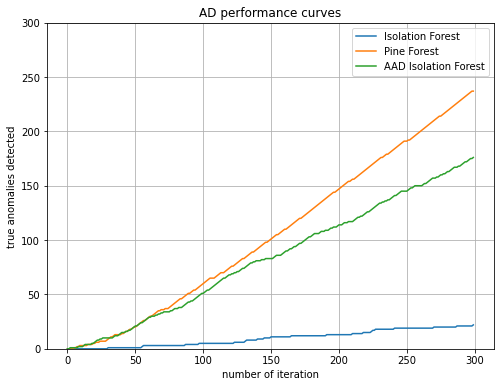

In [21]:
weather_cmp = CompareThem(WeatherData())
weather_cmp.run()
weather_cmp.plot()

In [31]:
elasticc_cmp = CompareThem(ELAsTiCC())
elasticc_cmp.run()
elasticc_cmp.plot()

ValueError: Buffer dtype mismatch, expected 'float32_t' but got 'double'